Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz
(28, 28)


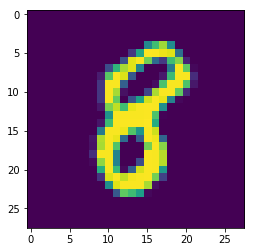

Size of:
Training-set:		55000
- Validation-set:	10000
- Test-set:		5000
Epoch 1/10... Discriminator Loss: 0.3371... Generator Loss: 4.9003
Epoch 2/10... Discriminator Loss: 0.3276... Generator Loss: 9.3219


KeyboardInterrupt: ignored

In [28]:
import matplotlib.pyplot as plt
from pickleshare import pickle
import pickle as pkl
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('data/fashion', source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/')

data_batch=mnist.train.next_batch(1)
data_batch=data_batch[0].reshape((28,28))
data_batch=np.array(data_batch)
print(data_batch.shape)
plt.imshow(data_batch)
plt.show()
print("Size of:")
print("Training-set:\t\t{}".format(len(mnist.train.labels)))
print("- Validation-set:\t{}".format(len(mnist.test.labels)))
print("- Test-set:\t\t{}".format(len(mnist.validation.labels)))

#defining placeholder variables for inputs

def placeholder(img_dim,z_dim):
	img_ph=tf.placeholder(tf.float32,(None,img_dim),name="image_data")
	z_ph=tf.placeholder(tf.float32,(None,z_dim),name="hidden_data")
	return img_ph,z_ph


def generator(z,out_dim,n_units,reuse):
  with tf.variable_scope('generator',reuse=reuse):
    #the hidden layer with n_units
    h1=tf.layers.dense(z,n_units,activation=tf.nn.relu)
    h1=tf.layers.dense(h1,n_units,activation=tf.nn.relu)
    h1=tf.layers.dense(h1,n_units,activation=tf.nn.relu)
    #output layer
    logits=tf.layers.dense(h1,out_dim,activation=None)
    out=tf.tanh(logits)
    return out

def discriminator(x,n_units,reuse=False):
  with tf.variable_scope('discriminator',reuse=reuse):
    #hidden layer with n_units
    h1=tf.layers.dense(x,n_units,activation=tf.nn.relu)

    h1=tf.layers.dense(h1,n_units,activation=tf.nn.relu)

    h1=tf.layers.dense(h1,n_units,activation=tf.nn.relu)
    #output layer
    logits=tf.layers.dense(h1,1,activation=None)
    out=tf.sigmoid(logits)
    return out,logits


input_size=784
z_dim=50
g_hidden=128
d_hidden=128
smoothing_param=0.1 # to keep the sigmoid betwen 0 and 0.9

#graph initiation
tf.reset_default_graph()
real_x, input_z=placeholder(input_size,z_dim)
#generator node
g_model=generator(input_z,input_size,g_hidden,reuse=False)
#discriminator node
#1. for real data
#2. for fake data(we'll use the same layer again )
d_model_real,d_logit_real=discriminator(real_x,d_hidden,False)
d_model_fake,d_logit_fake=discriminator(g_model,d_hidden,True)

#loss functions
#discriminator loss -> real loss,->fake loss
d_real_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_real,labels=tf.ones_like(d_logit_real)*(1-smoothing_param)))
d_fake_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake,labels=tf.zeros_like(d_logit_fake)))

total_d_loss=d_real_loss+d_fake_loss

#generator loss
g_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake,labels=tf.ones_like(d_logit_fake)))

#optimizer
lr=0.0005
t_var=tf.trainable_variables()
d_var=[var for var in t_var if var.name.startswith('discriminator')]
g_var=[var for var in t_var if var.name.startswith('generator')]

d_optimizer=tf.train.AdamOptimizer(lr).minimize(total_d_loss,var_list=d_var)
g_optimizer=tf.train.AdamOptimizer(lr).minimize(g_loss,var_list=g_var)


#start training

batch_size=128 #power of 2
epochs=10 # i don't have a GPU
samples=[] #to print some generated images
loss=[] #need to calm my heart

#save generator variables
gen_saved = tf.train.Saver(var_list=g_var)
k=3
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
      batch=mnist.train.next_batch(batch_size) #takes a batch size of 128 random images
      images=batch[0].reshape((batch_size,784))
      images=images*2-1

      #sample z
      for iii in range(k):
        z=np.random.uniform(-1,1,size=(batch_size,z_dim))
        sess.run(d_optimizer,feed_dict={real_x:images,input_z:z})
      
      z=np.random.uniform(-1,1,size=(batch_size,z_dim))
      sess.run(g_optimizer,feed_dict={input_z:z})

    train_loss_d=sess.run(total_d_loss,{input_z:z,real_x:images})
    train_loss_g=g_loss.eval({input_z:z})
    print("Epoch {}/{}...".format(i+1, epochs),
                "Discriminator Loss: {:.4f}...".format(train_loss_d),
                "Generator Loss: {:.4f}".format(train_loss_g))
    loss.append((train_loss_d,train_loss_g))
    sample_z = np.random.uniform(-1, 1, size=(16, z_dim))
    gen_samples=sess.run(generator(input_z,input_size,g_hidden,reuse=True),feed_dict={input_z:sample_z})
    samples.append(gen_samples)
    gen_saved.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)


def view_samples(epoch, samples):
	print("i'm here")
	fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
	for ax, img in zip(axes.flatten(), samples[epoch]):
		ax.xaxis.set_visible(True)
		ax.yaxis.set_visible(True)
		im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
	return fig, axes
  
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

print("calling")
print(len(samples))
p=view_samples(-1,samples)
plt.show()






